In [57]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
class Loan:

    @staticmethod
    def get_recurring_payment_c(*, n, p, r):
        return p * (r * (1 + r)**n) / ((1 + r)**n - 1)
    
    @staticmethod
    def get_current_rate_r(*, k, r, Rs: pd.DataFrame | None, month):
        if Rs is not None:
            rel_Rs = Rs[month >= Rs['month']]['rate']
            if len(rel_Rs) > 0:
                R = rel_Rs.iloc[-1]
                r = R / k
        return r

    def __init__(self, *, N, k, P, R0):
        self.N = N
        self.k = k
        self.P = P
        self.R0 = R0
        
        self.n = self.N * self.k
        self.r0 = self.R0 / self.k
        self.c0 = self.get_recurring_payment_c(n=self.n, p=self.P, r=self.r0)
        self.m0 = self.c0 * self.k / 12
    
    def print(self):
        print('--- Configuration ---')
        print('Term length N:', self.N, 'yrs')
        print('Payments per year k:', self.k)
        print('Principal P:', self.P)
        print('Initial interest R0:', self.R0 * 100, '% pa')
        print('')
        print('--- Analysis ---')
        print('Initial payment per month m0:', f'{self.m0:.2f}')
        print('Initial total amount to be paid:', f'{(self.n * self.c0):.2f}')
        print('Initial total interest to be paid: ', f'{(self.n * self.c0 - self.P):.2f}', f'({((self.n * self.c0 - self.P) / (self.n * self.c0) * 100):.2f}', '%)')
        print('')

    def simulate(self, *,  Rs):
        plan = []

        p = self.P
        r = self.r0
        i = 0
        while p > 0:
            month = i * 12 / self.k

            r = self.get_current_rate_r(r=r, k=self.k, Rs=Rs, month=month)
            c = self.get_recurring_payment_c(n=self.n - i, p=p, r=r)

            i += 1
            month = i * 12 / self.k
            year = i / self.k

            total_paid = c
            interest_paid = p * r
            principal_paid = total_paid - interest_paid
            p -= principal_paid

            plan.append((i, month, year, total_paid, interest_paid, principal_paid, p))
        
        plan = pd.DataFrame(plan, columns=['i', 'month', 'year', 'total', 'interest', 'principal', 'remaining'])
        plan.set_index('i', drop=False, inplace=True)

        print('--- Simulation ---')
        print(plan.head(5))
        print('---')
        print(plan.tail(5))

        return plan

In [59]:
P = 1100000
N = 20
k = 12
R0 = 0.065

Rs = []
Rs.append((24, 0.055))
Rs.append((48, 0.065))
Rs = pd.DataFrame(Rs, columns=['month', 'rate'])
Rs.set_index('month', drop=False, inplace=True)

In [60]:
myLoan1 = Loan(N=N, k=k, P=P, R0=R0)
myLoan1.print()
plan1 = myLoan1.simulate(Rs=None)

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)

--- Simulation ---
   i  month      year        total     interest    principal     remaining
i                                                                         
1  1    1.0  0.083333  8201.304491  5958.333333  2242.971157  1.097757e+06
2  2    2.0  0.166667  8201.304491  5946.183906  2255.120584  1.095502e+06
3  3    3.0  0.250000  8201.304491  5933.968670  2267.335821  1.093235e+06
4  4    4.0  0.333333  8201.304491  5921.687267  2279.617223  1.090955e+06
5  5    5.0  0.416667  8201.304491  5909.339341  2291.965150  1.088663e+06
---
       i  month       year        total    interest    principal     remaining
i                                                                             
236  236  236.0  1

In [61]:
myLoan2 = Loan(N=N, k=k, P=P, R0=R0)
myLoan2.print()
plan2 = myLoan2.simulate(Rs=Rs)

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)

--- Simulation ---
   i  month      year        total     interest    principal     remaining
i                                                                         
1  1    1.0  0.083333  8201.304491  5958.333333  2242.971157  1.097757e+06
2  2    2.0  0.166667  8201.304491  5946.183906  2255.120584  1.095502e+06
3  3    3.0  0.250000  8201.304491  5933.968670  2267.335821  1.093235e+06
4  4    4.0  0.333333  8201.304491  5921.687267  2279.617223  1.090955e+06
5  5    5.0  0.416667  8201.304491  5909.339341  2291.965150  1.088663e+06
---
       i  month       year       total    interest    principal     remaining
i                                                                            
236  236  236.0  19.

In [62]:
def plot(ax1, plan: pd.DataFrame):
    ax2 = ax1.twinx()
    # axis 1

    ax1.plot(plan['year'], plan['remaining'], 'k-', label='remaining')

    principal_half = plan.loc[plan['remaining'] <= 0.5 * plan['remaining'].iloc[0]].iloc[0]
    ax1.axhline(y=principal_half['remaining'], color='y', linestyle='-')
    ax1.axvline(x=principal_half['year'], color='y', linestyle='-')

    ax1.set_xlabel('Years')
    ax1.set_ylabel('Remaining')
    ax1.legend(loc='lower left')

    # axis 2

    ax2.plot(plan['year'], plan['interest'], 'r--', label='interest')
    ax2.plot(plan['year'], plan['principal'], 'g--', label='principal')
    ax2.plot(plan['year'], plan['interest'] + plan['principal'], 'b--', label='interest + principal')

    interest_principal_turnover = plan.loc[plan['principal'] >= plan['interest']].iloc[0]
    ax2.axhline(y=interest_principal_turnover['principal'], color='y', linestyle='--')
    ax2.axvline(x=interest_principal_turnover['year'], color='y', linestyle='--')

    ax2.set_ylabel('Payment per month')
    ax2.legend(loc='center right')

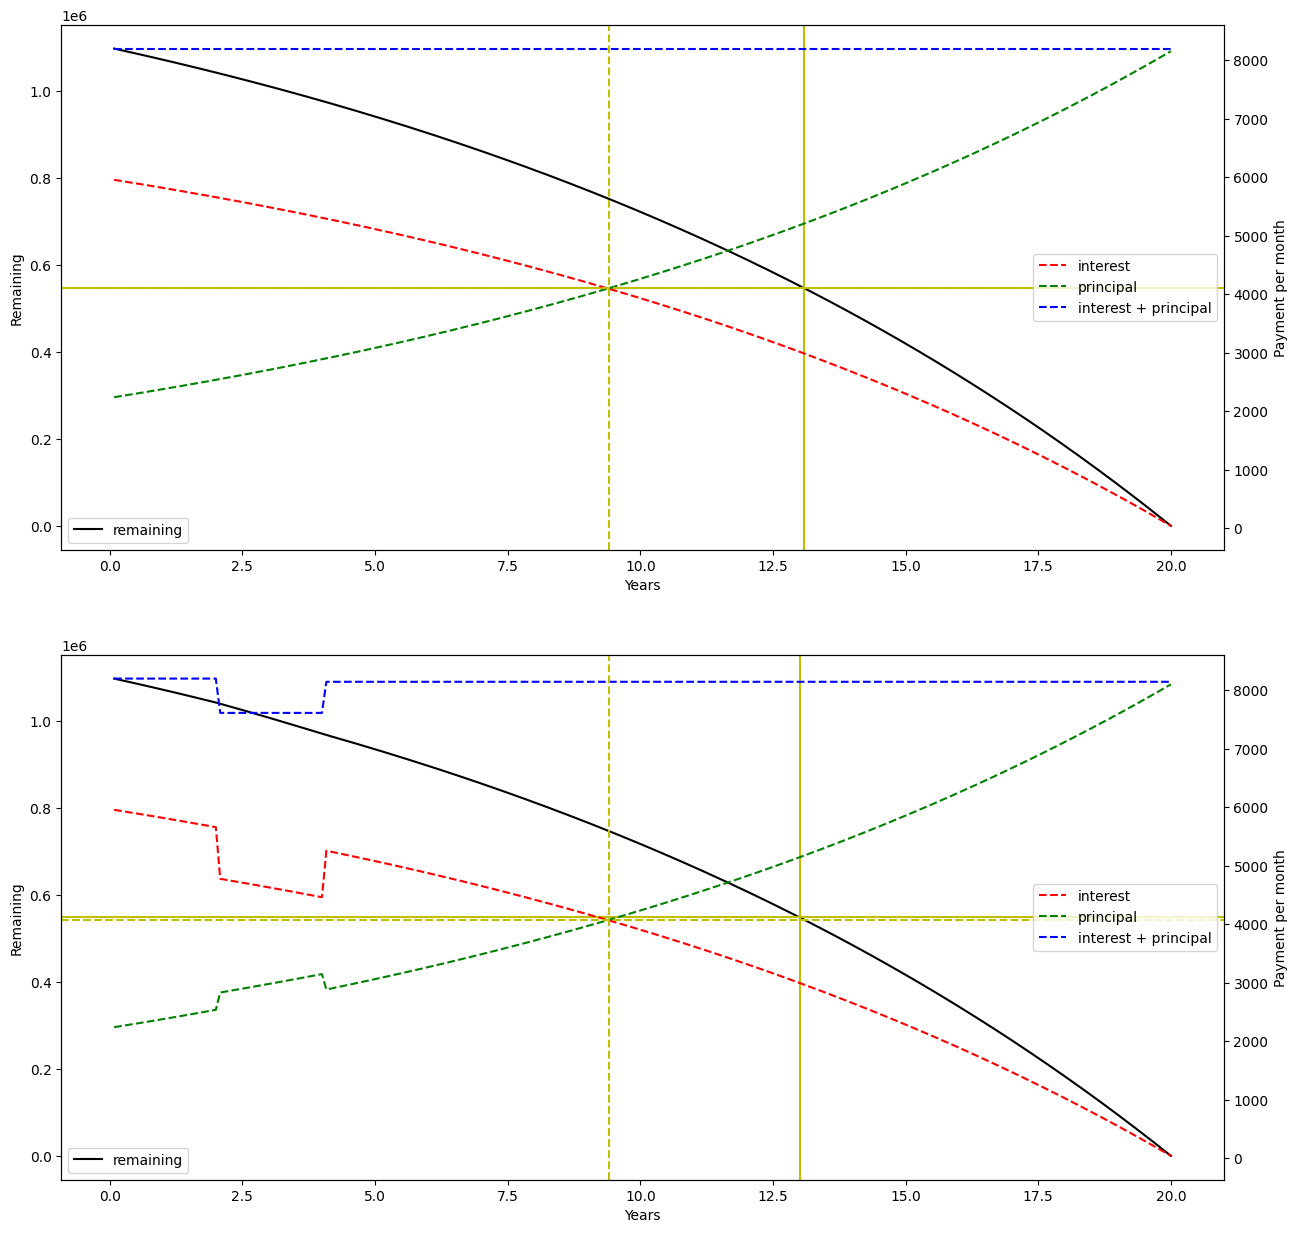

In [63]:
fig, axs = plt.subplots(nrows=2, figsize=(15,15))

plot(axs[0], plan1)
plot(axs[1], plan2)

plt.show()